In [ ]:
# the goal here is to get a few run results, and calculate plot some entropy stuff,
# determine what would be a good bandwidth value
# this is especially important for the final_position bd, since that have a large and variable range

# TODO
# open  relevan example runs (can (should) be ES run)
# load data
# plot behavior data
# calculate kde for single point
# calculate kde for grid, plot




In [1]:
import os
import wandb
import copy 
import json

import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np

import analyse_results_utils

In [2]:
api = wandb.Api()
jax_es_sweep = api.sweep("adam_katona/uncategorized/jd18zi1o") 
sweep_runs = list(jax_es_sweep.runs)

In [3]:
all_runs = []
failed_runs = []
for i,wanddb_run in enumerate(sweep_runs):
    if i%40 == 0:
        print(i,"/",len(sweep_runs))
    run_logs = wanddb_run.history()
    if len(run_logs) == 0:
        failed_runs.append(wanddb_run.config)
    else:
        run = {
            "wandb_run" : wanddb_run,
            "run_logs" : run_logs,
            "config" : wanddb_run.config,
            
        }
        all_runs.append(run)

0 / 540
40 / 540
80 / 540
120 / 540
160 / 540
200 / 540
240 / 540
280 / 540
320 / 540
360 / 540
400 / 540
440 / 540
480 / 540
520 / 540


In [4]:
def id_to_path(id):
    from glob import glob    
    path = glob("/scratch/ak1774/runs/large_files_jax/*"+id, recursive = False)[0]
    return path

In [5]:
# Add path and load rollout results
for i,run in enumerate(all_runs):
    if i%40 == 0:
        print(i,"/",len(all_runs))
    run_id = run["wandb_run"].dir.split("/")[-1]
    run["path"] = id_to_path(run_id)
    
    rollout_arrays = np.load(run["path"]+"/final_rollout_arrays.npz",allow_pickle=True)["arr_0"].item()
    run["rollout_results"] = rollout_arrays

0 / 485
40 / 485
80 / 485
120 / 485
160 / 485
200 / 485
240 / 485
280 / 485
320 / 485
360 / 485
400 / 485
440 / 485
480 / 485


In [6]:
# now some functions which can do this with multiple keys
def get_unique_combinations(runs,keys):
    all_tuples = []
    for run in runs:
        all_tuples.append(tuple(run["config"][key] for key in keys))
    return set(all_tuples)

def select_where_keys_are(runs,keys,key_values):
    selected_runs = []
    for run in runs:
        if tuple(run["config"][key] for key in keys) == key_values:
            selected_runs.append(run)
    return selected_runs
    
def group_by_keys(runs,keys):
    unique_vals = get_unique_combinations(runs,keys)
    return {val:select_where_keys_are(runs,keys,val) for val in unique_vals}

# group runs togeather which have same config but different run_id
def group_runs_with_same_conf(runs):
    grouped_runs = {}
    for run in runs:
        run_conf = copy.deepcopy(run["config"])
        run_conf["RUN_ID"] = 0
        run_conf = json.dumps(run_conf)
        if run_conf in grouped_runs:
            grouped_runs[run_conf].append(run)
        else:
            grouped_runs[run_conf] = [run]
    return grouped_runs

In [7]:
grouped_runs = group_by_keys(all_runs,["env_name","env_mode"])
# sort
grouped_runs = {k: grouped_runs[k] for k in sorted(grouped_runs,key=lambda x: x[0])}
grouped_runs = {k: group_runs_with_same_conf(grouped_runs[k]) for k in grouped_runs}

In [8]:
for a,b in grouped_runs.items():
    print(a,len(b))

('ant', 'DISTANCE_CONTACT') 9
('ant', 'DIRECTIONAL_CONTACT') 9
('ant', 'NORMAL_FINAL_POS') 9
('ant', 'DISTANCE_FINAL_POS') 9
('ant', 'CONTROL_FINAL_POS') 9
('ant', 'NORMAL_CONTACT') 10
('halfcheetah', 'CONTROL_FINAL_POS') 9
('halfcheetah', 'NORMAL_CONTACT') 9
('halfcheetah', 'DISTANCE_CONTACT') 9
('halfcheetah', 'NORMAL_FINAL_POS') 9
('halfcheetah', 'DISTANCE_FINAL_POS') 9
('hopper', 'CONTROL_FINAL_POS') 9
('hopper', 'NORMAL_CONTACT') 9
('hopper', 'DISTANCE_CONTACT') 9
('hopper', 'NORMAL_FINAL_POS') 9
('hopper', 'DISTANCE_FINAL_POS') 9
('humanoid', 'DISTANCE_CONTACT') 9
('humanoid', 'DIRECTIONAL_CONTACT') 9
('humanoid', 'NORMAL_FINAL_POS') 9
('humanoid', 'DISTANCE_FINAL_POS') 9
('humanoid', 'CONTROL_FINAL_POS') 9
('humanoid', 'NORMAL_CONTACT') 9
('walker', 'NORMAL_FINAL_POS') 9
('walker', 'DISTANCE_FINAL_POS') 9
('walker', 'CONTROL_FINAL_POS') 9
('walker', 'NORMAL_CONTACT') 9
('walker', 'DISTANCE_CONTACT') 9


In [47]:
#a = grouped_runs[('ant', 'NORMAL_CONTACT')]
#b = grouped_runs[('ant', 'NORMAL_FINAL_POS')]
a = grouped_runs[('humanoid', 'NORMAL_CONTACT')]
b = grouped_runs[('humanoid', 'NORMAL_FINAL_POS')]
for key,run_list in b.items():
    print("".join(str(mode) for mode in run_list[0]["config"]["ES_UPDATES_MODES_TO_USE"]))
    
contact_run = list(a.values())[0][0]
contact_config = contact_run["config"]
contact_pos = contact_run["rollout_results"]["final_pos"]
contact_bds = contact_run["rollout_results"]["bds"]

pos_run = list(b.values())[0][0]
pos_config = pos_run["config"]
pos_pos = pos_run["rollout_results"]["final_pos"]
pos_bds = pos_run["rollout_results"]["bds"]

quality_evo_ent_innovation
quality_evo_var_innovation
quality_innovation
quality_evo_ent
quality_evo_var
innovation
evo_ent
evo_var
fitness


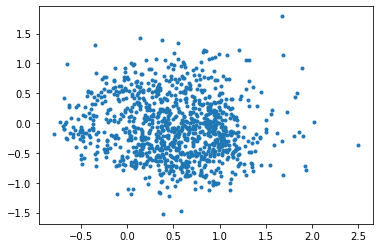

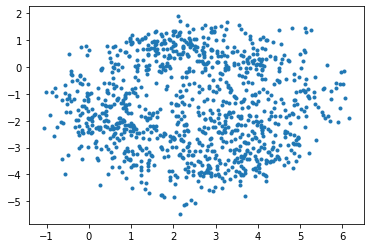

In [48]:
plt.plot(contact_pos[:,0],contact_pos[:,1],".")
plt.show()
plt.plot(pos_pos[:,0],pos_pos[:,1],".")

In [25]:
run["rollout_results"].keys()

dict_keys(['control_cost_fitness', 'forward_fitness', 'distance_walked', 'normal_fitness', 'final_pos', 'foot_contacts', 'fitnesses', 'bds'])

In [28]:
pos_pos.shape

(1050, 2)

In [22]:
type(bds)

numpy.ndarray

In [36]:
np.std(pos_bds,axis=0)

array([6.8122187, 6.941912 ], dtype=float32)

In [40]:
from scipy import stats
kernel = stats.gaussian_kde(pos_bds.T)

In [41]:
kernel


None


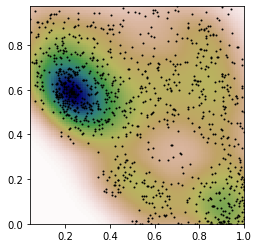

0.1


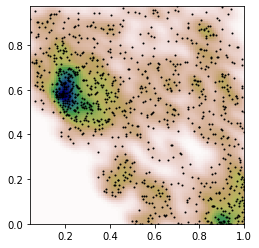

0.25


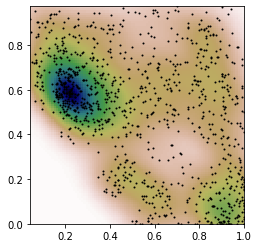

1


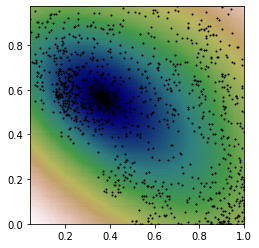

3


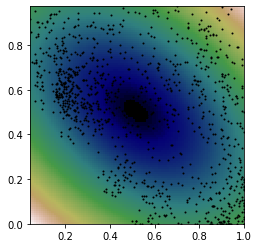

In [50]:
# must be 2d
#bds = pos_bds
bds = contact_bds

xmin = bds[:,0].min()
xmax = bds[:,0].max()
ymin = bds[:,1].min()
ymax = bds[:,1].max()


for bandwidth in [None,0.1,0.25,1,3]:
    print(bandwidth)
    kernel = stats.gaussian_kde(bds.T)
    if bandwidth is not None:
        kernel.set_bandwidth(bandwidth)

    X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([X.ravel(), Y.ravel()])
    #values = np.vstack([m1, m2])
    #kernel = stats.gaussian_kde(values)
    Z = np.reshape(kernel(positions).T, X.shape)


    import matplotlib.pyplot as plt
    fig, ax = plt.subplots()
    ax.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r,
              extent=[xmin, xmax, ymin, ymax])
    ax.plot(bds[:,0], bds[:,1], 'k.', markersize=2)
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    plt.show()